<a href="https://colab.research.google.com/github/antonshalin76/DataScientist/blob/main/Segmentation/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_PSP_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В сегментированном датасете Стройка измените количество сегментирующих классов с `16` на `7`
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

Постройте модель для сегментации изображений по этому классификатору.

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D, Dropout

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

from tensorflow.keras import utils

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:13<00:00, 16.1MB/s]


In [ ]:
# Глобальные параметры

IMG_WIDTH = 192               # Ширина картинки
IMG_HEIGHT = 256              # Высота картинки
CLASS_COUNT = 7              # Количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

In [ ]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')):

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))

    return image_list

In [ ]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original')
val_images = load_imageset(VAL_DIRECTORY, 'original')

# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment')
val_segments = load_imageset(VAL_DIRECTORY, 'segment')

In [ ]:
# Цвета пикселов сегментированных изображений

FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)

CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

CLASS_0 = (FLOOR)
CLASS_1 = (CEILING)
CLASS_2 = (WALL)
CLASS_3 = (APERTURE)#, DOOR, WINDOW)
CLASS_4 = (COLUMN)#, RAILINGS, LADDER)
CLASS_5 = (INVENTORY)
CLASS_6 = (LAMP)#, WIRE, BEAM, EXTERNAL, BATTERY, PEOPLE)

NUM_CLASS = (CLASS_0, CLASS_1, CLASS_2, CLASS_3, CLASS_4, CLASS_5, CLASS_6)

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

        result.append(y)

    return np.array(result)

# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(NUM_CLASS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = NUM_CLASS[i]

        result.append(temp)

    return np.array(result)

In [ ]:
# Формирование обучающей выборки

x_train = []                          # Cписок под обучающую выборку

for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_train.append(x)                 # Добавление элемента в x_train

x_train = np.array(x_train)           # Перевод всей выборки в numpy

# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy

print(x_train.shape)                  # Форма x_train
print(x_val.shape)                    # Форма x_val

# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

(1900, 192, 256, 3)
(100, 192, 256, 3)



In [ ]:
# Перепаковка сегментированных данных в 7 классов
'''
CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

0_класс - FLOOR
1_класс - CEILING
2_класс - WALL
3_класс - APERTURE, DOOR, WINDOW
4_класс - COLUMN, RAILINGS, LADDER
5_класс - INVENTORY
6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY, PEOPLE

'''
y_train7 = y_train.copy()
y_train7[(y_train7 == 4) | (y_train7 == 5) | (y_train7 == 6)] = 30
y_train7[(y_train7 == 3) | (y_train7 == 8) | (y_train7 == 11)] = 4
y_train7[y_train7 == 30] = 3
y_train7[y_train7 == 12] = 5
y_train7[(y_train7 == 7) | (y_train7 == 9) | (y_train7 == 10) | (y_train7 == 13) | (y_train7 == 14) | (y_train7 == 15)] = 6

y_val7 = y_val.copy()
y_val7[(y_val7 == 4) | (y_val7 == 5) | (y_val7 == 6)] = 30
y_val7[(y_val7 == 3) | (y_val7 == 8) | (y_val7 == 11)] = 4
y_val7[y_val7 == 30] = 3
y_val7[y_val7 == 12] = 5
y_val7[(y_val7 == 7) | (y_val7 == 9) | (y_val7 == 10) | (y_val7 == 13) | (y_val7 == 14) | (y_val7 == 15)] = 6

print(y_train7.shape)
print(y_val7.shape)

(1900, 192, 256, 1)
(100, 192, 256, 1)


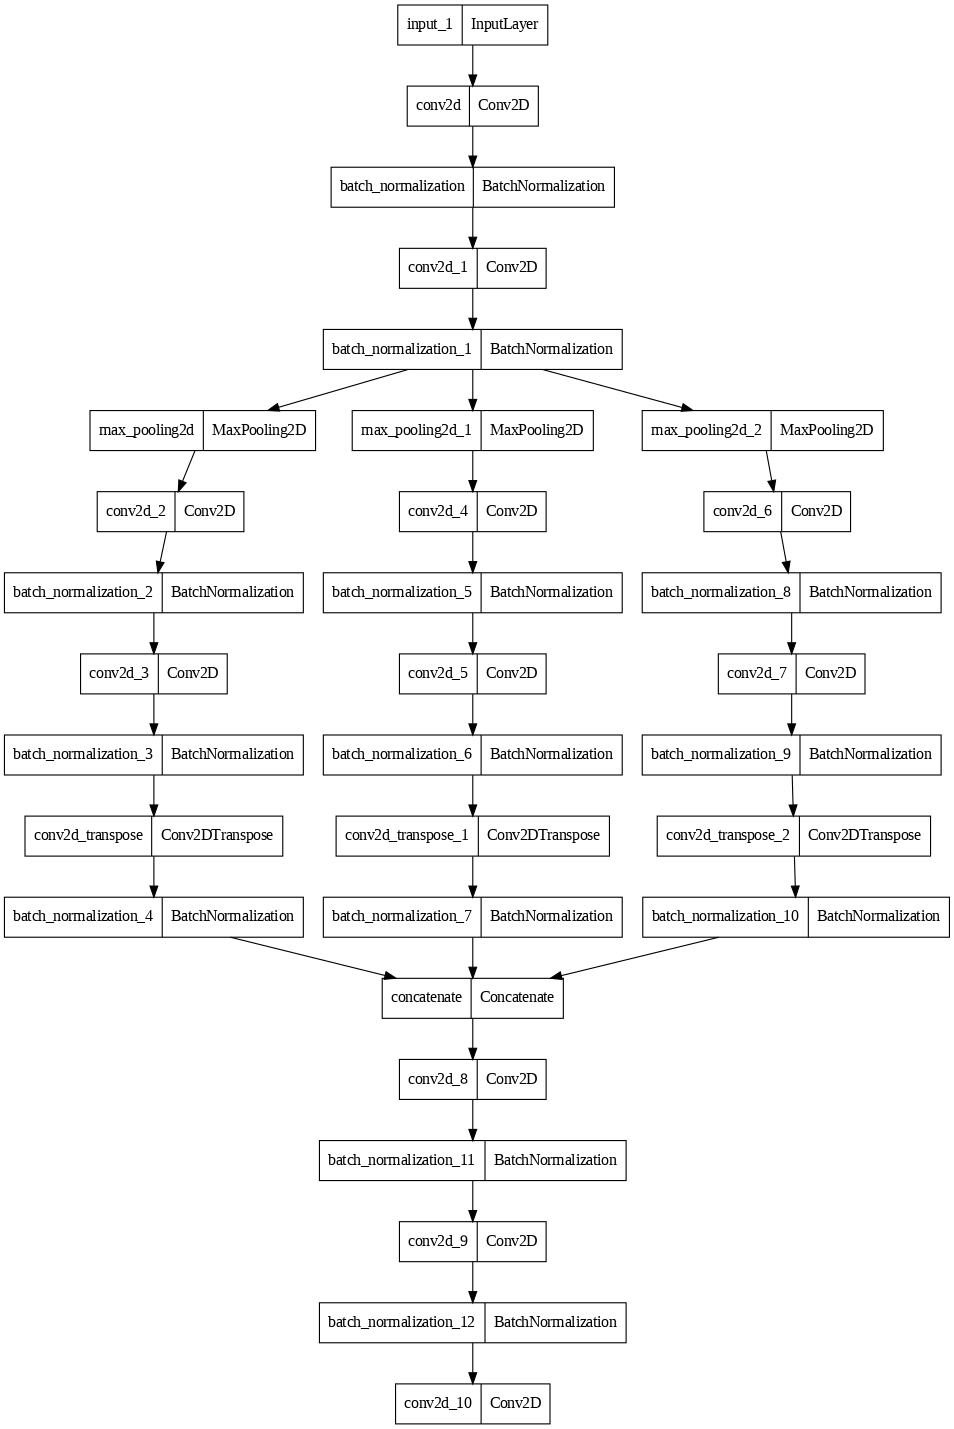

In [ ]:
# Модель

img_input = Input((IMG_WIDTH, IMG_HEIGHT, 3))

''' Block 1 '''
x = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
block_in_out = BatchNormalization()(x)

''' Block 2.1 '''
x1 = MaxPooling2D(2)(block_in_out)

x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)

x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x1 = BatchNormalization()(x1)

x1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu', padding='same')(x1)
block_1_out = BatchNormalization()(x1)

''' Block 2.2 '''
x2 = MaxPooling2D(4)(block_in_out)

x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
x2 = BatchNormalization()(x2)

x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
x2 = BatchNormalization()(x2)

x2 = Conv2DTranspose(64, (4, 4), strides=(4, 4), activation='relu', padding='same')(x2)
block_2_out = BatchNormalization()(x2)

''' Block 2.3 '''
x3 = MaxPooling2D(8)(block_in_out)

x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)
x3 = BatchNormalization()(x3)

x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)
x3 = BatchNormalization()(x3)

x3 = Conv2DTranspose(64, (8, 8), strides=(8, 8), activation='relu', padding='same')(x3)
block_3_out = BatchNormalization()(x3)

''' Block 3 '''
x = concatenate([block_1_out, block_2_out, block_3_out])

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(CLASS_COUNT, (3, 3), activation='softmax', padding='same')(x)

model = Model(img_input, x)

# Компилируем модель
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

utils.plot_model(model, dpi=80)

In [ ]:
gc.collect() # почистим память
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 192, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 192, 256, 64)         36928     ['batch_normalization[0][0

Epoch 1/20
60/60 [==============================] - 47s 777ms/step - loss: 0.4790 - sparse_categorical_accuracy: 0.8318 - val_loss: 1.0567 - val_sparse_categorical_accuracy: 0.6539
Epoch 2/20
60/60 [==============================] - 47s 780ms/step - loss: 0.4701 - sparse_categorical_accuracy: 0.8340 - val_loss: 1.0661 - val_sparse_categorical_accuracy: 0.6601
Epoch 3/20
60/60 [==============================] - 47s 792ms/step - loss: 0.4628 - sparse_categorical_accuracy: 0.8370 - val_loss: 1.0545 - val_sparse_categorical_accuracy: 0.6526
Epoch 4/20
60/60 [==============================] - 47s 784ms/step - loss: 0.4598 - sparse_categorical_accuracy: 0.8388 - val_loss: 1.0774 - val_sparse_categorical_accuracy: 0.6601
Epoch 5/20
60/60 [==============================] - 47s 782ms/step - loss: 0.4537 - sparse_categorical_accuracy: 0.8403 - val_loss: 1.0925 - val_sparse_categorical_accuracy: 0.6445
Epoch 6/20
60/60 [==============================] - 47s 783ms/step - loss: 0.4494 - sparse_cate

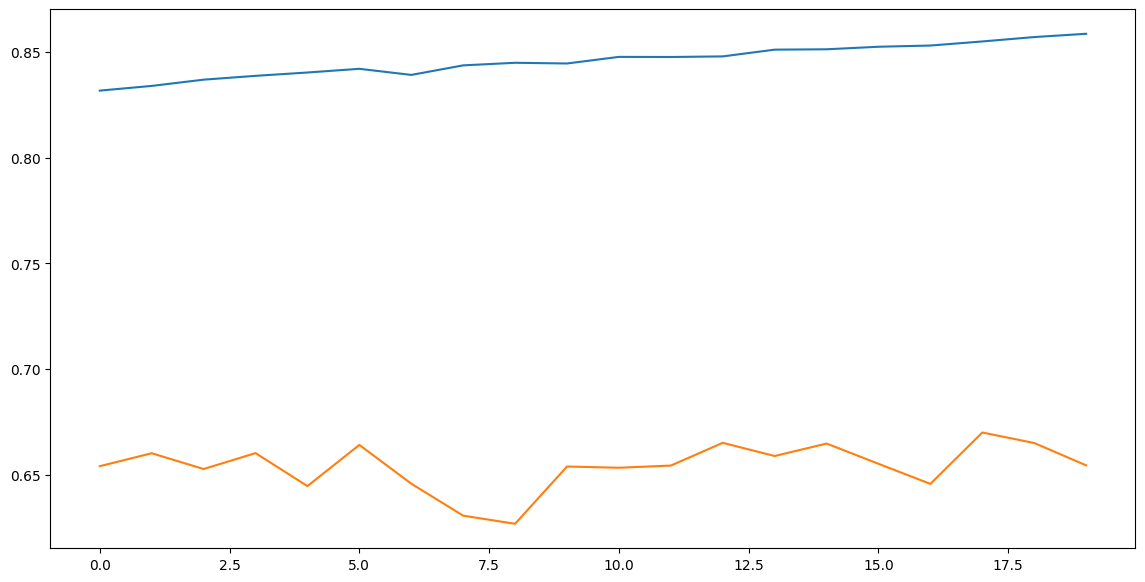

In [ ]:
# Обучение модели

history = model.fit(x_train, y_train7,
                        epochs=20, batch_size=32,
                        validation_data=(x_val, y_val7))

# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

In [ ]:
# Функция визуализации процесса сегментации изображений

def process_images(model,        # обученная модель
                   count = 1     # количество случайных картинок для сегментации
                   ):

    # Генерация случайного списка индексов в количестве count между (0, len(x_val)
    indexes = np.random.randint(0, len(x_val), count)

    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes], verbose=0), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 15))

    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show()

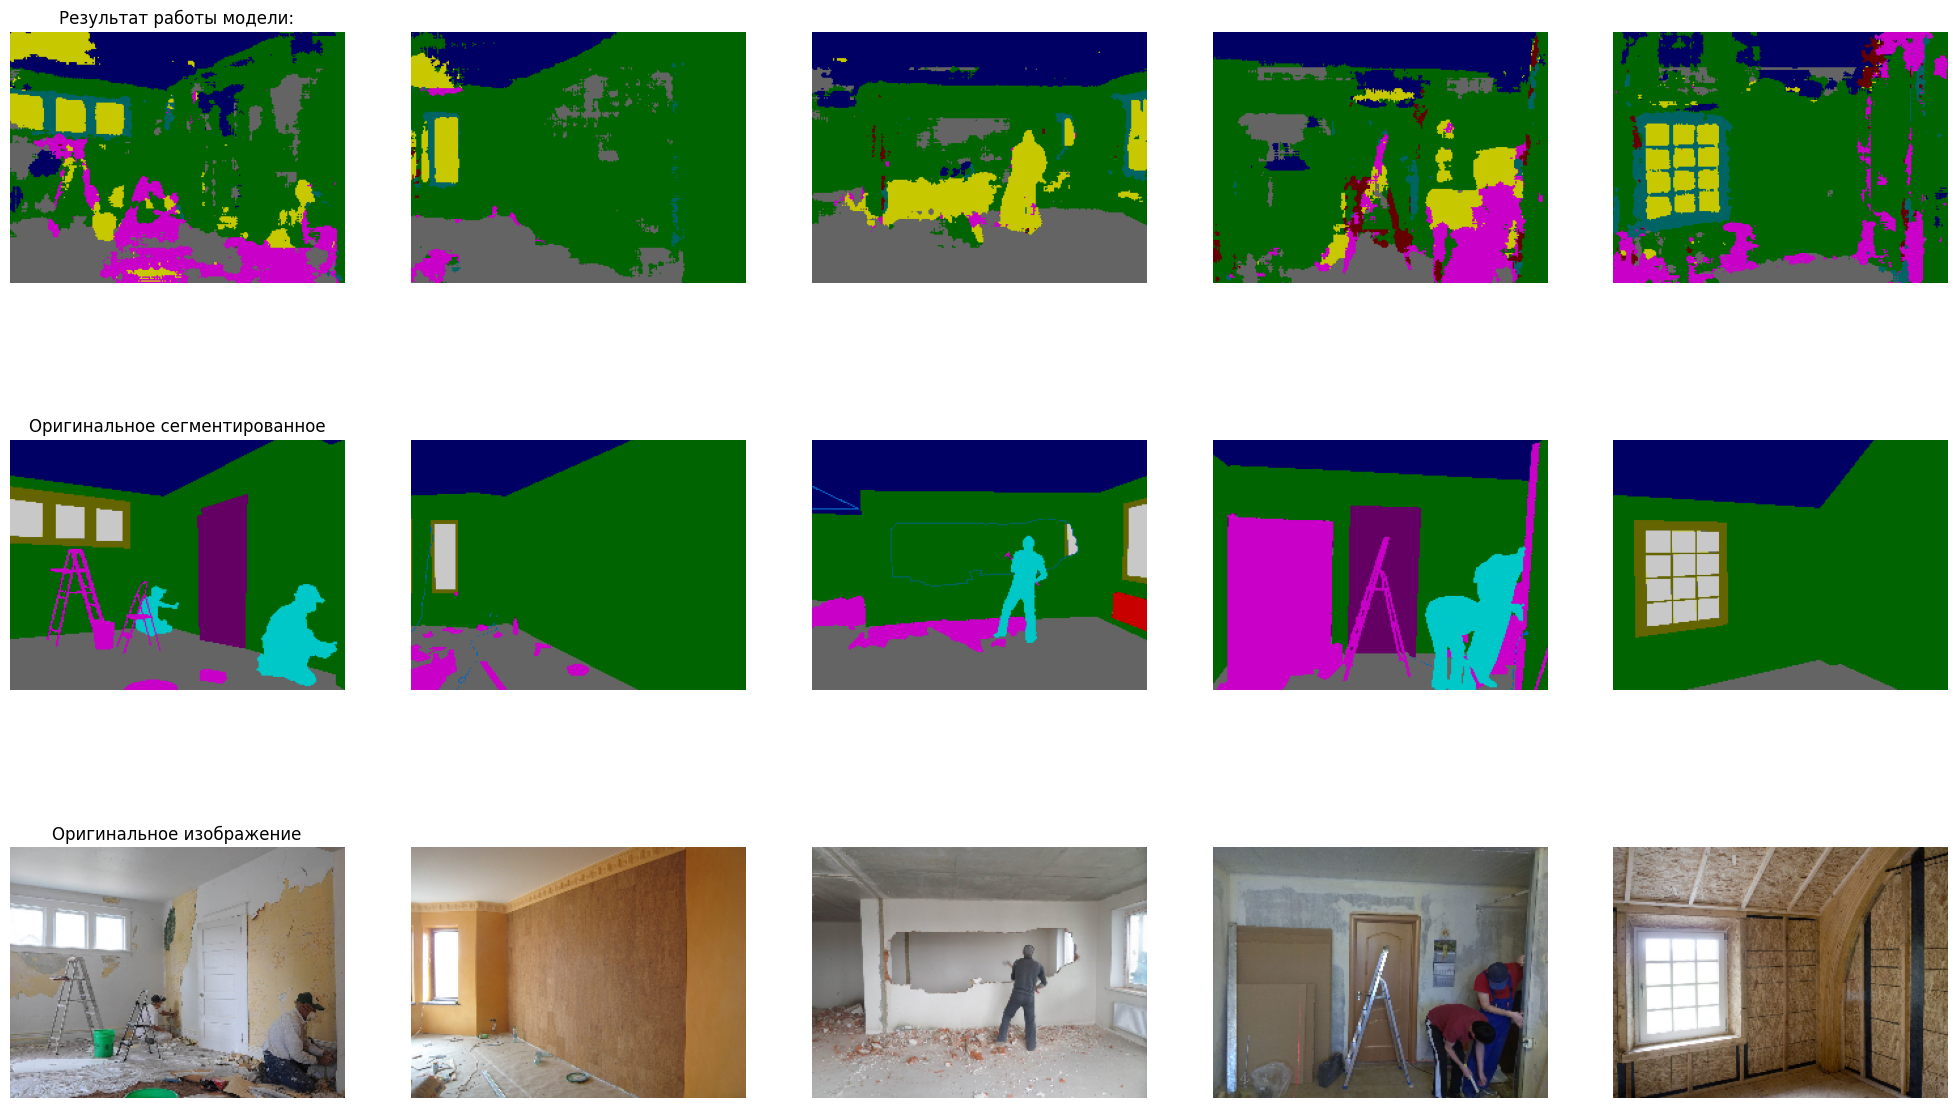

In [ ]:
gc.collect() # почистим память

# Отображение результатов работы модели

process_images(model, 5)